This is a modified example of using textsplit for segmenation of documents. see the original file: https://github.com/chschock/textsplit/blob/master/notebooks/HowTo.ipynb

Instead of the word2vec model I have tried Gensim

In [1]:
import os
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import os
import urllib.request
import zipfile
from gensim.models import KeyedVectors


## Download toy corpus for wordvector training and example text

In [2]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    url = 'http://mattmahoney.net/dc/text8.zip'
    zip_path = 'text8.zip'
    
    # Download the file
    print(f"Downloading {url}...")
    urllib.request.urlretrieve(url, zip_path)
    print("Download complete.")
    
    # Extract the zip file
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")
    
    # Remove the zip file after extraction
    os.remove(zip_path)


links = {
    'tale2cities': 'https://www.gutenberg.org/files/98/98-0.txt',  # A Tale of Two Cities
    'siddhartha': 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'  # Siddhartha
}

for name, link in links.items():
    text_path = f"{name}.txt"
    if not os.path.exists(text_path):
        print(f"Downloading {link}...")
        urllib.request.urlretrieve(link, text_path)
        print(f"Downloaded {text_path}.")


Download complete.
Extracting text8.zip...
Extraction complete.
Downloaded tale2cities.txt.
Downloaded siddhartha.txt.


## Train wordvectors

In [3]:
with open(corpus_path, 'r') as file:
    corpus = file.read().splitlines()
sentences = [line.split() for line in corpus]
model = Word2Vec(
    sentences,
    vector_size=200,  # 'size' is now 'vector_size'
    window=15,
    sg=0,             # CBOW if 0, Skip-gram if 1
    hs=1,
    epochs=5,         # 'iter_' is now 'epochs'
    workers=8,
    sample=1e-5
)
wrdvec_path = 'wrdvecs.bin'
model.wv.save_word2vec_format(wrdvec_path, binary=True)
loaded_model = KeyedVectors.load_word2vec_format(wrdvec_path, binary=True)
wrdvecs = pd.DataFrame(loaded_model.vectors, index=loaded_model.key_to_index)
print(wrdvecs.shape)


(71290, 200)


## get sentence tokenizer

In [4]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [5]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

penalty 0.00
814 sentences, 158 segments, avg 5.15 sentences per segment
optimal score 22363.59, greedy score 22363.00
ratio of scores 1.0000


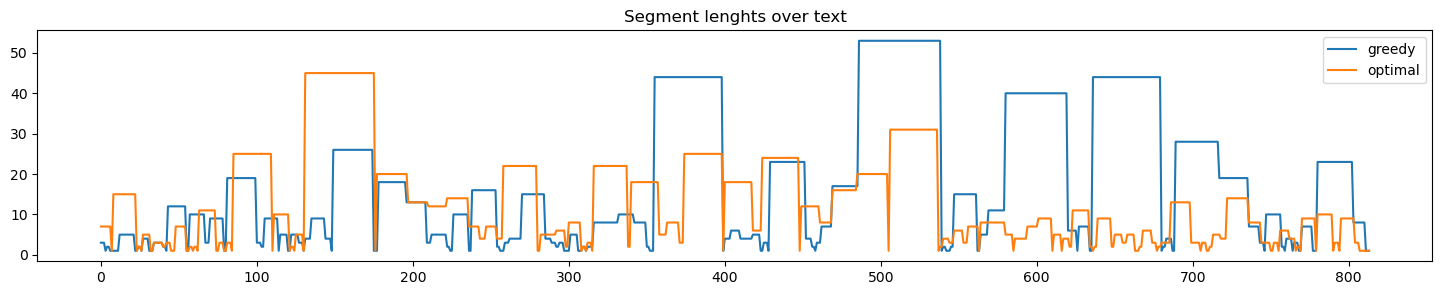

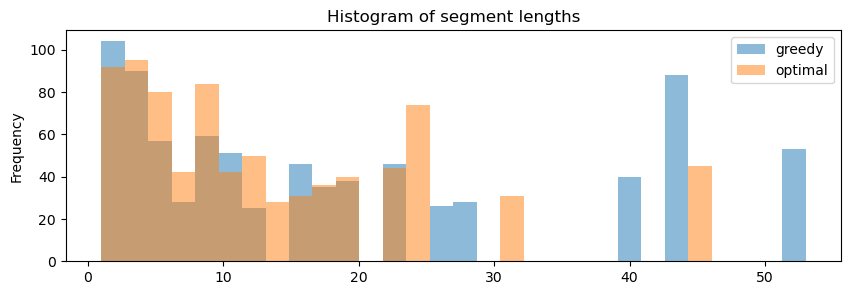

In [6]:
# link = links['siddartha']
link = links['tale2cities']
segment_len = 30  # segment target length in sentences
book_path = 'tale2cities.txt'
book_path = r"C:\Users\imanm\OneDrive\Documents\podcast\robert engels\processed_Robert_Iman Podcast-20241203_090154-Meeting Recording_transcription.txt"

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [9]:
optimal_segmentation

Segmentation(total=22363.649274053798, splits=[7, 8, 23, 24, 26, 27, 32, 33, 34, 37, 40, 42, 45, 46, 47, 48, 55, 56, 57, 59, 60, 62, 63, 74, 75, 76, 79, 80, 81, 84, 85, 110, 111, 121, 122, 124, 125, 130, 131, 176, 177, 197, 210, 222, 236, 243, 247, 254, 258, 280, 281, 282, 287, 292, 298, 300, 308, 309, 311, 312, 315, 316, 338, 340, 358, 363, 371, 374, 399, 400, 418, 424, 448, 449, 461, 469, 485, 505, 506, 537, 538, 540, 544, 547, 553, 556, 563, 564, 572, 580, 585, 586, 590, 594, 601, 610, 611, 616, 617, 621, 623, 634, 636, 637, 639, 648, 650, 655, 658, 663, 664, 665, 666, 668, 674, 677, 678, 680, 683, 686, 699, 702, 705, 706, 709, 710, 711, 713, 718, 722, 736, 744, 747, 750, 751, 752, 755, 756, 762, 766, 767, 769, 770, 779, 780, 790, 791, 794, 795, 804, 807, 808, 809, 810, 811, 812, 813], gains=[0.0016659702105812357, 0.0016577311072296652, 0.04044619147100548, 0.034454242220662026, 0.07291353136881362, 0.0011682990948571614, 0.0009155009964558758, 0.0012234111076505627, 0.001131955709

## Evaluation

If you look into the written file `book_path`.seg, the snippet line is often at the boundary of a paragraph.  The word embeddings computed above are neither very good nor adapted to the text. Every unknown word has a zero vector. Choosing some more or less random vector for unknown words might improve the accuracy given those unknown terms appear repeatedly within a section.